# Started another Notebook on the Titanic Machine Learning

### This time, I'll follow an advanced method inspired by Güneş Evitan (Kaggle User)

**Import modules**

In [1]:
import numpy as np # Numerical Python
import pandas as pd # Data Analysis

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Machine learning Modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


import string # Process standard Python strings
import warnings # useful to alert the user of some condition in a program
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combined = concat_df(train, test)

train.name = 'Training Set'
test.name = 'Test Set'
combined.name = 'All Set' 

trainAndtest = [train, test]

print('Number of Training Examples = {}'.format(train.shape[0]))
print('Number of Test Examples = {}\n'.format(test.shape[0]))
print('Training X Shape = {}'.format(train.shape))
print('Training y Shape = {}\n'.format(train['Survived'].shape[0]))
print('Test X Shape = {}'.format(test.shape))
print('Test y Shape = {}\n'.format(test.shape[0]))
print(train.columns)
print(test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

**Exploratory Data Analysis**

*This method prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.*

*Information about the Titanic dataset, index dtype & column dtype, non-null values and memory usage*

In [3]:
print(train.info())
train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.7500,NaN,Q
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C


**Missing Values in The Titanic Dataset**

In [4]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in trainAndtest:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




**Working to fill missing values**

*Find the correlation coefficient of age against other features in the dataset*

In [5]:
combined_corr = combined.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
combined_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
combined_corr[combined_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


**Sex feature is used as the second level of groupby**

*`Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases.*

In [6]:
agebyPclass_sex = combined.groupby(['Sex', 'Pclass']).median()['Age']
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, agebyPclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(combined['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [7]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
combined['Age'] = combined.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [8]:
display_missing(combined)

Age column missing values: 0
Cabin column missing values: 1014
Embarked column missing values: 2
Fare column missing values: 1
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 418
Ticket column missing values: 0




In [9]:
combined['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [10]:
combined['Age'].tail()

1304    25.0
1305    39.0
1306    38.5
1307    25.0
1308    25.0
Name: Age, dtype: float64

**Working on the missing values in Embarked**

*Embarked has 2 missing observations, they share same Ticket number, same cabin, same class...*

In [11]:
combined[combined['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


*The author of the notebook googled the name of the survivor and found out she boarded from Southampton, it makes sense to fill the missing value for Embarked with S*

In [12]:
# Filling the missing values in Embarked with S
combined['Embarked'] = combined['Embarked'].fillna('S')

In [13]:
combined[combined['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket


In [14]:
display_missing(combined)

Age column missing values: 0
Cabin column missing values: 1014
Embarked column missing values: 0
Fare column missing values: 1
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 418
Ticket column missing values: 0




**Working on the missing value in Fare**

*There's only one passenger with a missing fare value*

*Let me read the observation 👇🏽 *

In [15]:
combined[combined['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


*The passenger with the missing fare value is in his 60's, with no kids on board, on the 3rd class ticket..*

*The median fare value of males with no children and in third class should be a fair way to go...*

In [16]:
# A groupby of 3rd class. 0 Parch, & 0 SibSp
medianFare = combined.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
medianFare

7.8542

In [17]:
# Fill the missing value in Fare with the medianfare
combined['Fare'] = combined['Fare'].fillna(medianFare)

In [18]:
combined[combined['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket


In [19]:
display_missing(combined)

Age column missing values: 0
Cabin column missing values: 1014
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 418
Ticket column missing values: 0




**Working on the missing value in Cabin**

In [20]:
# Checking for missing values
combined[combined['Cabin'].isnull()].head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,25.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909


In [21]:
list(combined['Cabin'])[0:10]

[nan, 'C85', nan, 'C123', nan, nan, 'E46', nan, nan, nan]

In [22]:
# Create a new column that indicates if the passengers had a cabin or not
combined['HasCabin'] = ~combined.Cabin.isnull()

In [23]:
# The new column
combined['HasCabin'].head()

0    False
1     True
2    False
3     True
4    False
Name: HasCabin, dtype: bool

In [24]:
# Drop the Cabin feature
combined.drop(['Cabin'], axis=1, inplace=True)

In [25]:
combined.head(3)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,HasCabin
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,False
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,True
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,False


In [26]:
# Plotting a chart for the distribution of HasCabins to Survived
dist = combined[['Survived', 'HasCabin']]
dist.shape

(1309, 2)

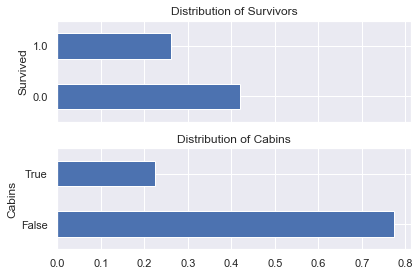

In [27]:
fig, ax = plt.subplots(2, 1, sharex=True)

dist_target = dist.shape[0]

(combined['Survived']
    .value_counts()
    .div(dist_target)
    .plot.barh(title="Distribution of Survivors", ax=ax[0])
)
ax[0].set_ylabel("Survived")

(combined['HasCabin']
    .value_counts()
    .div(dist_target)
    .plot.barh(title="Distribution of Cabins", ax=ax[1])
)
ax[1].set_ylabel("Cabins")


fig.tight_layout()

**Dropping the Cabin Feature**

In [28]:
# Dropping the Cabin feature
#combined.drop(['Cabin'], inplace=True, axis=1)

train, test = divide_df(combined)
combined = [train, test]

for df in combined:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
HasCabin column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
HasCabin column missing values: 0




**Distribution of the target variable**

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


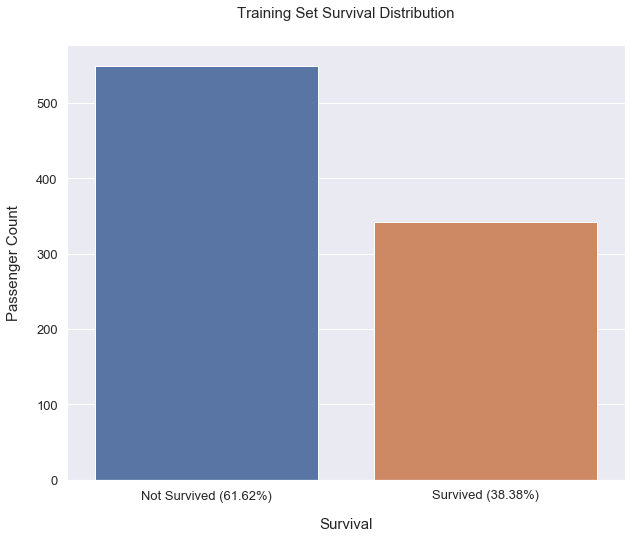

In [29]:
survived = train['Survived'].value_counts()[1]
notSurvived = train['Survived'].value_counts()[0]
percentage_survived = survived / train.shape[0] * 100
percentage_notSurvived = notSurvived / train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, train.shape[0], percentage_survived))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(notSurvived, train.shape[0], percentage_notSurvived))

plt.figure(figsize=(10, 8))
sns.countplot(train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(percentage_notSurvived), 'Survived ({0:.2f}%)'.format(percentage_survived)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

In [30]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


**Feature Correlations**

In [31]:
train_correlation = train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
train_correlation.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
train_correlation.drop(train_correlation.iloc[1::2].index, inplace=True)
train_correlation_nd = train_correlation.drop(train_correlation[train_correlation['Correlation Coefficient'] == 1.0].index)

test_correlation = test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
test_correlation.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
test_correlation.drop(test_correlation.iloc[1::2].index, inplace=True)
test_correlation_nd = test_correlation.drop(test_correlation[test_correlation['Correlation Coefficient'] == 1.0].index)

In [32]:
# Training data correlations greater than 0.1
correlations = train_correlation_nd['Correlation Coefficient'] > 0.1
train_correlation_nd[correlations]

,Feature 1,Feature 2,Correlation Coefficient
8,HasCabin,Pclass,0.725541
10,Pclass,Fare,0.549500
12,Fare,HasCabin,0.482075
14,Pclass,Age,0.417667
16,Parch,SibSp,0.414838
18,Pclass,Survived,0.338481
20,Survived,HasCabin,0.316912
22,Age,HasCabin,0.278741
24,Survived,Fare,0.257307
26,SibSp,Age,0.249747


In [33]:
# Test data correlations greater than 0.1
correlations = test_correlation_nd['Correlation Coefficient'] > 0.1
test_correlation_nd[correlations]

,Feature 1,Feature 2,Correlation Coefficient
8,Pclass,HasCabin,0.690579
10,Fare,Pclass,0.577489
12,Fare,HasCabin,0.561118
14,Pclass,Age,0.526789
16,HasCabin,Age,0.391885
18,Fare,Age,0.345347
20,Parch,SibSp,0.306895
22,Fare,Parch,0.230410
24,SibSp,Fare,0.172032


**Visualizing the train and test correlations using heatmaps**

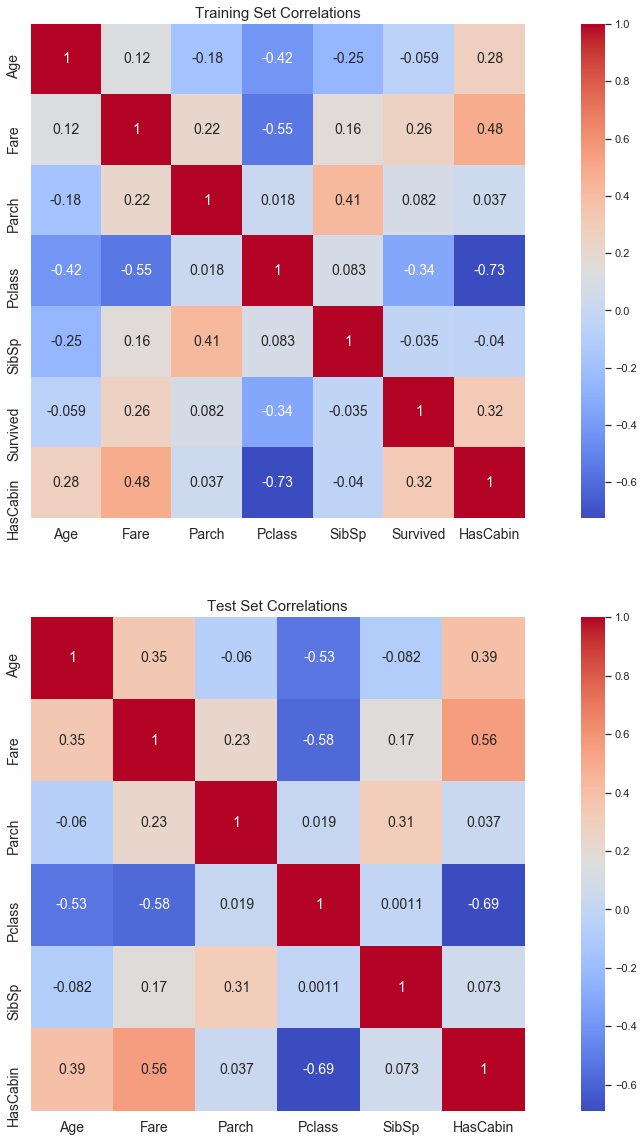

In [34]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(train.drop(['PassengerId'], axis=1).corr(),
            ax=axs[0],
            annot=True,
            square=True,
            cmap='coolwarm',
            annot_kws={'size': 14})
sns.heatmap(test.drop(['PassengerId'], axis=1).corr(),
            ax=axs[1],
            annot=True,
            square=True,
            cmap='coolwarm',
            annot_kws={'size': 14})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)

axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

**Plotting the distribution of features**

*Will the model generalize because of these distributions?* 🤷🏽‍♂️

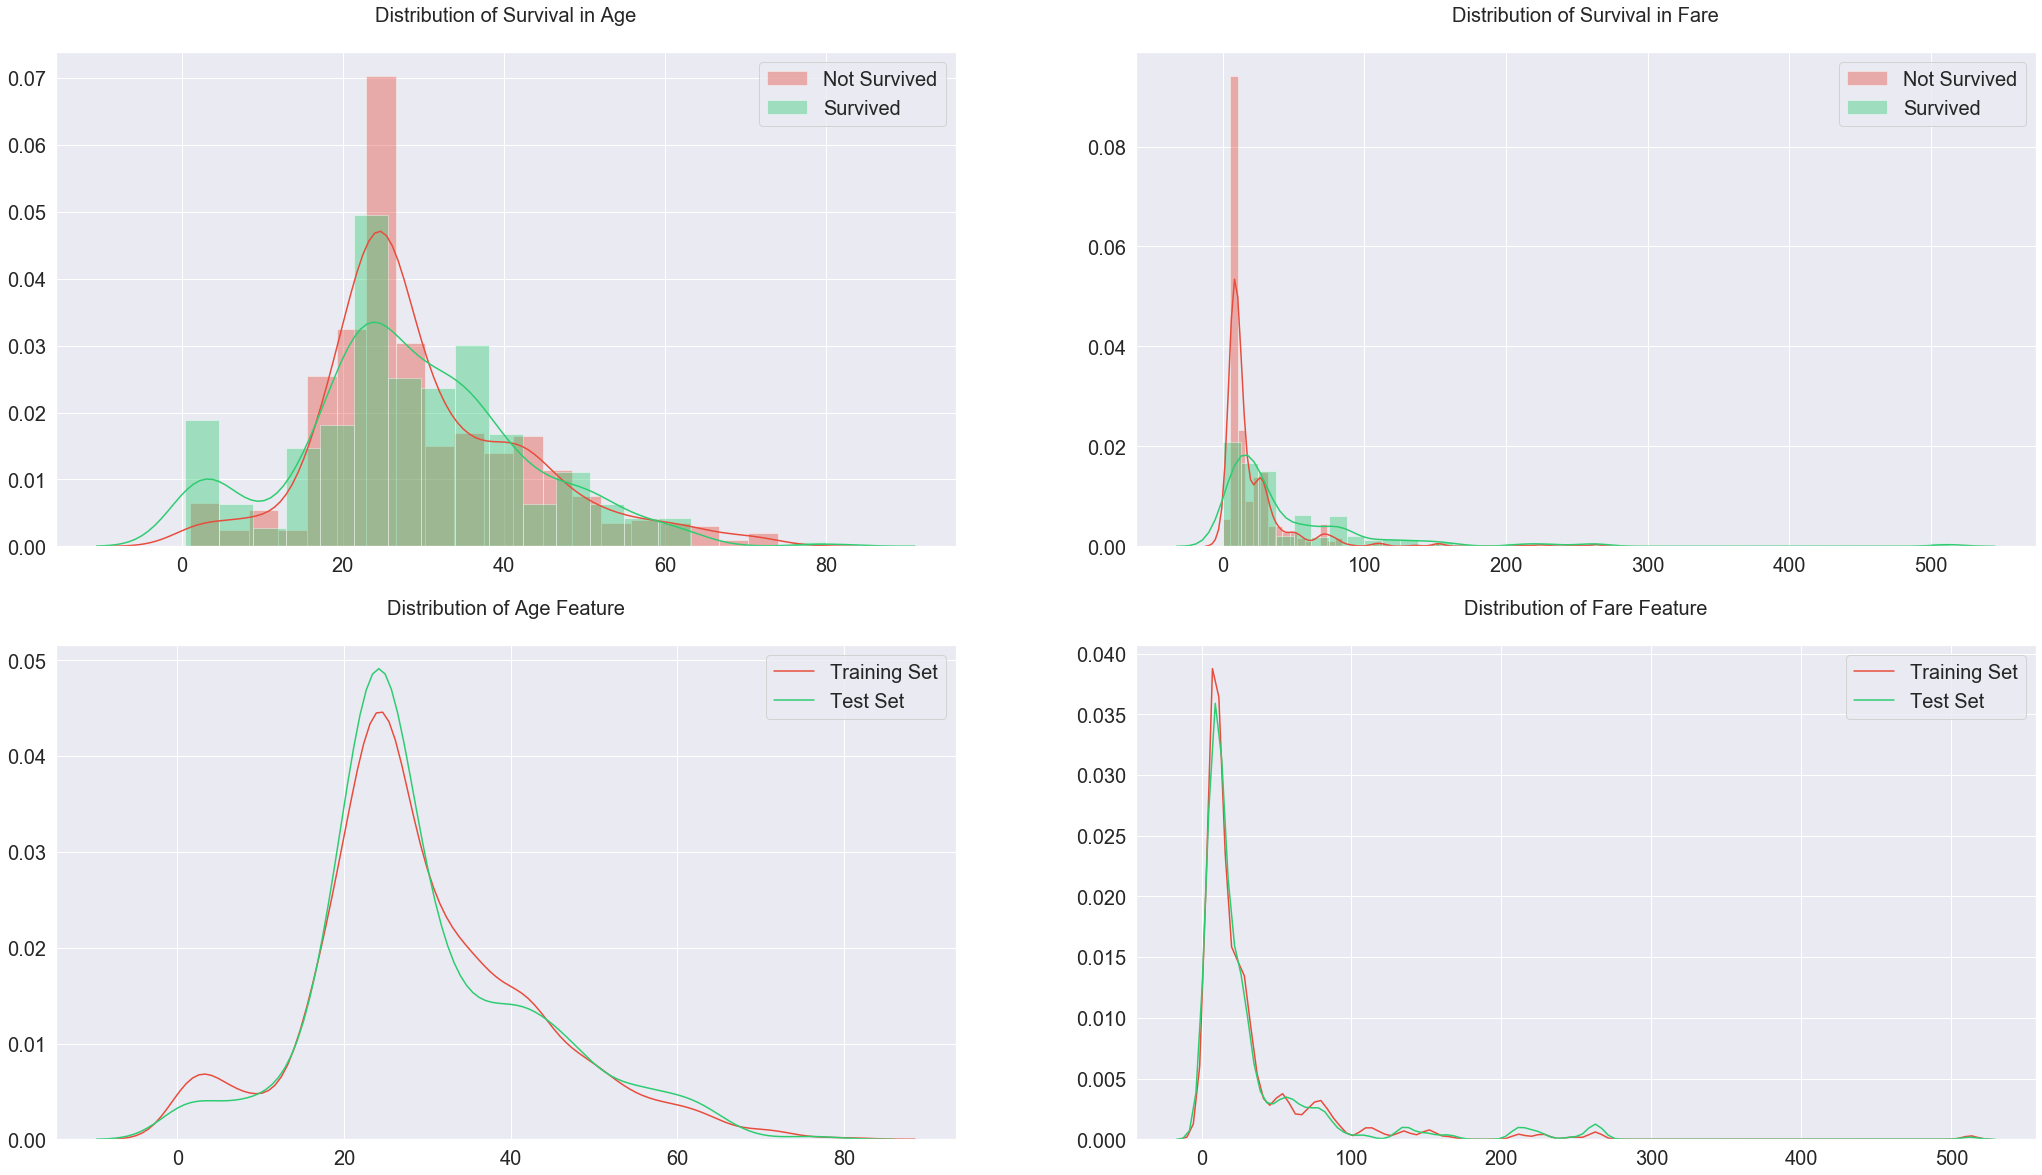

In [35]:
twoFeatures = ['Age', 'Fare'] # Age & Fare features
survived = train['Survived'] == 1 

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20)) #Xtics of the plot
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(twoFeatures):
    # Distribution of survival in feature
    sns.distplot(train[~survived][feature],
                 label='Not Survived',
                 hist=True,
                 color='#e74c3c',
                 ax=axs[0][i])
    sns.distplot(train[survived][feature],
                 label='Survived',
                 hist=True,
                 color='#2ecc71',
                 ax=axs[0][i])

    # Distribution of feature in dataset
    sns.distplot(train[feature],
                 label='Training Set',
                 hist=False,
                 color='#e74c3c',
                 ax=axs[1][i])
    sns.distplot(test[feature],
                 label='Test Set',
                 hist=False,
                 color='#2ecc71',
                 ax=axs[1][i])

    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')

    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)

    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature),
                        size=20,
                        y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'),
                    size=20,
                    y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'),
                    size=20,
                    y=1.05)

plt.show()

**The distribution of Categorical Features to Survived**

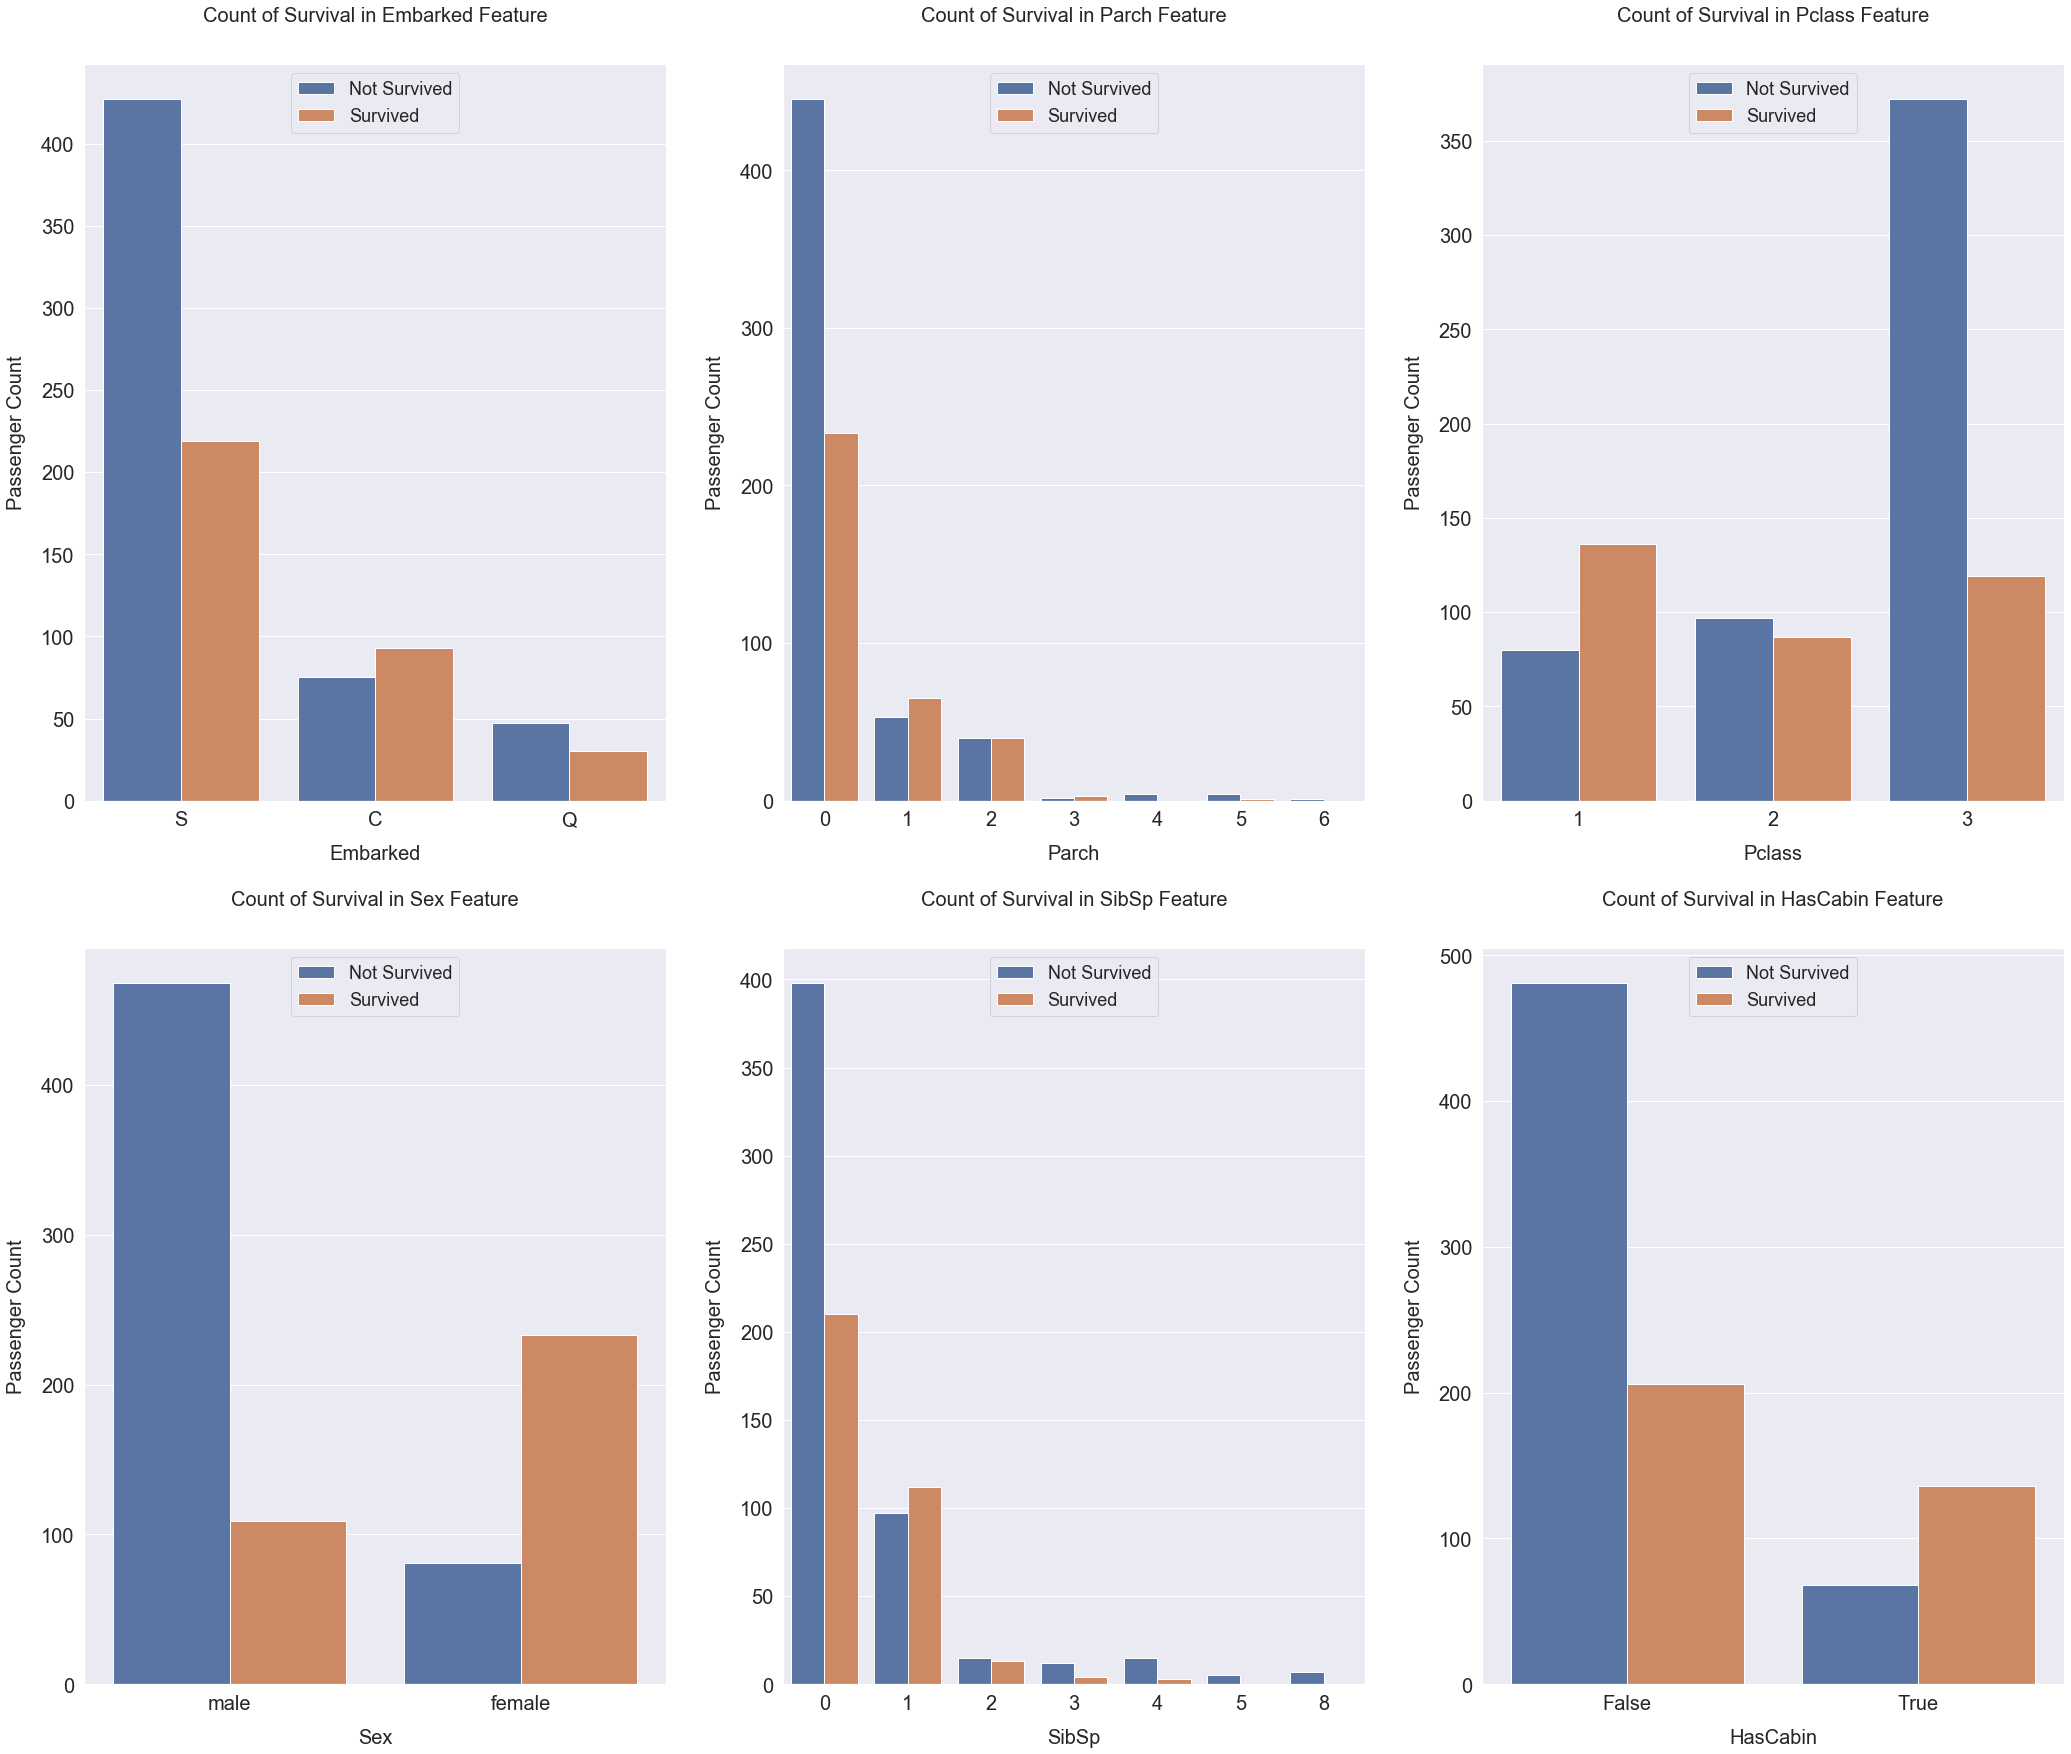

In [36]:
categoricalFeatures = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'HasCabin']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(categoricalFeatures, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

In [37]:
combined = concat_df(train, test)

**Feature Engineering**

In [38]:
# Discretize variable into equal-sized buckets based on rank or based on sample quantiles
combined['Fare'] = pd.qcut(combined['Fare'], 13)

In [39]:
combined['Fare'].head()

0      (-0.001, 7.25]
1    (56.496, 83.475]
2       (7.896, 8.05]
3    (34.075, 56.496]
4       (7.896, 8.05]
Name: Fare, dtype: category
Categories (13, interval[float64]): [(-0.001, 7.25] < (7.25, 7.75] < (7.75, 7.896] < (7.896, 8.05] ... (26.55, 34.075] < (34.075, 56.496] < (56.496, 83.475] < (83.475, 512.329]]

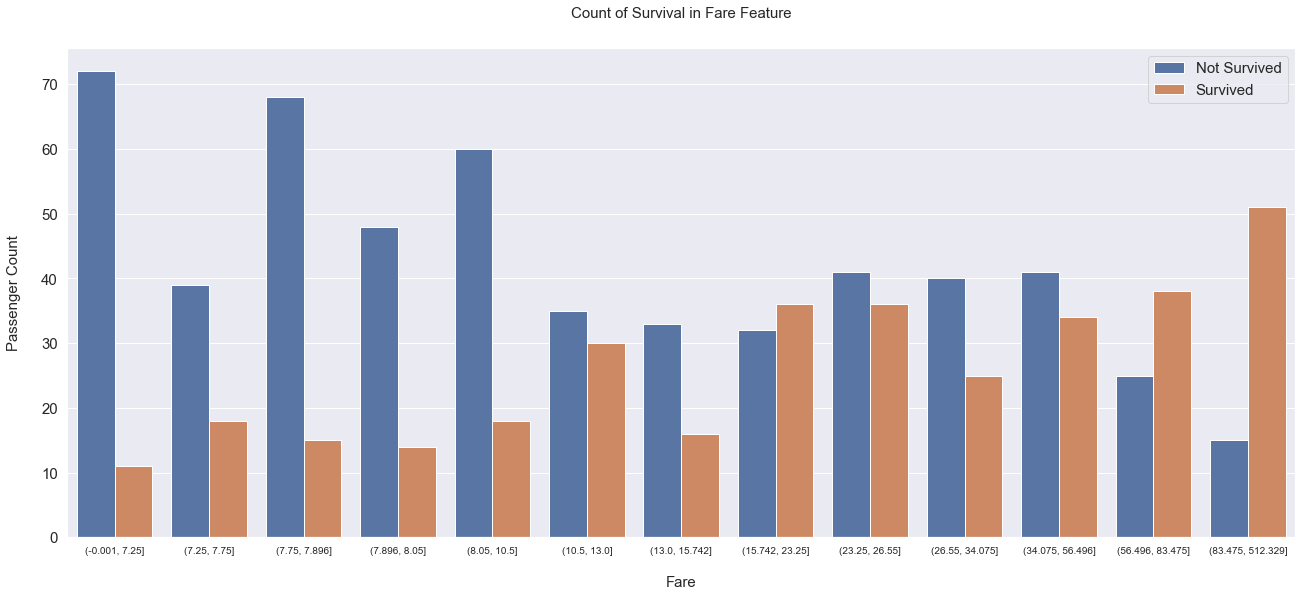

In [40]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=combined)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

In [41]:
# Discretizing the Age feature, plotting the distribution and here 👇🏽
combined['Age'] = pd.qcut(combined['Age'], 10)

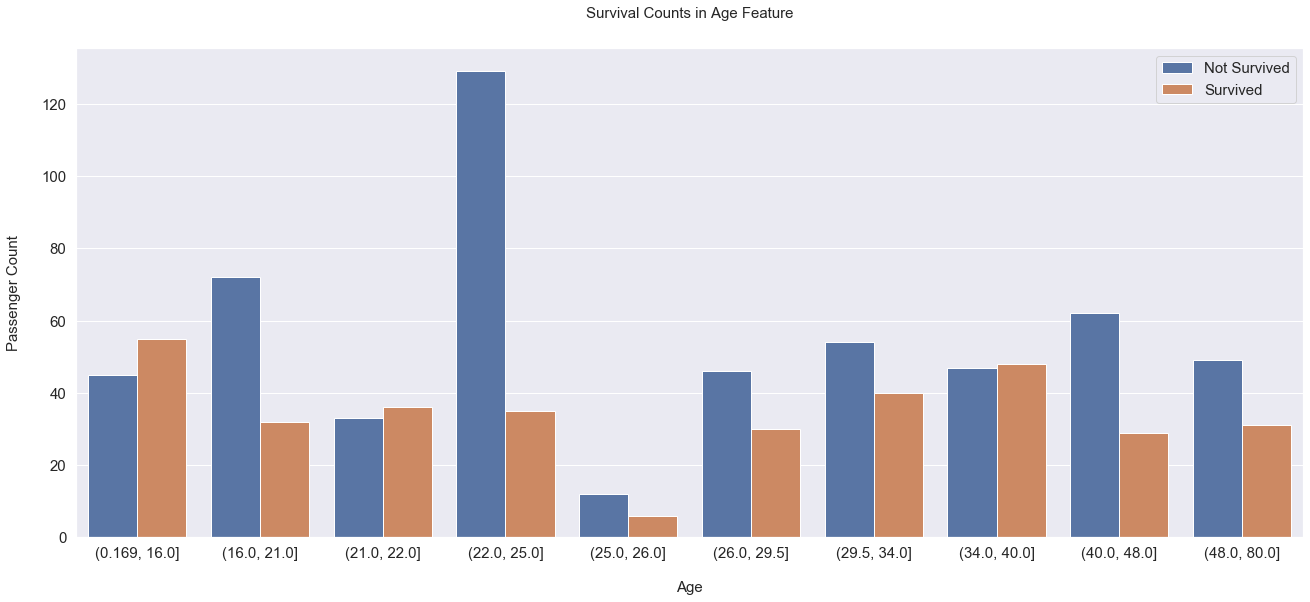

In [42]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=combined)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

**Sibsp & Parch**

*Creating Family size + 1 as alone*

*Family size of 2,3, & 4 as small*

*Family size of 5 & 6 as medium*

*Family size of 7,8, & 11 as large*

**Creating a frequency from the Features mentioned above**

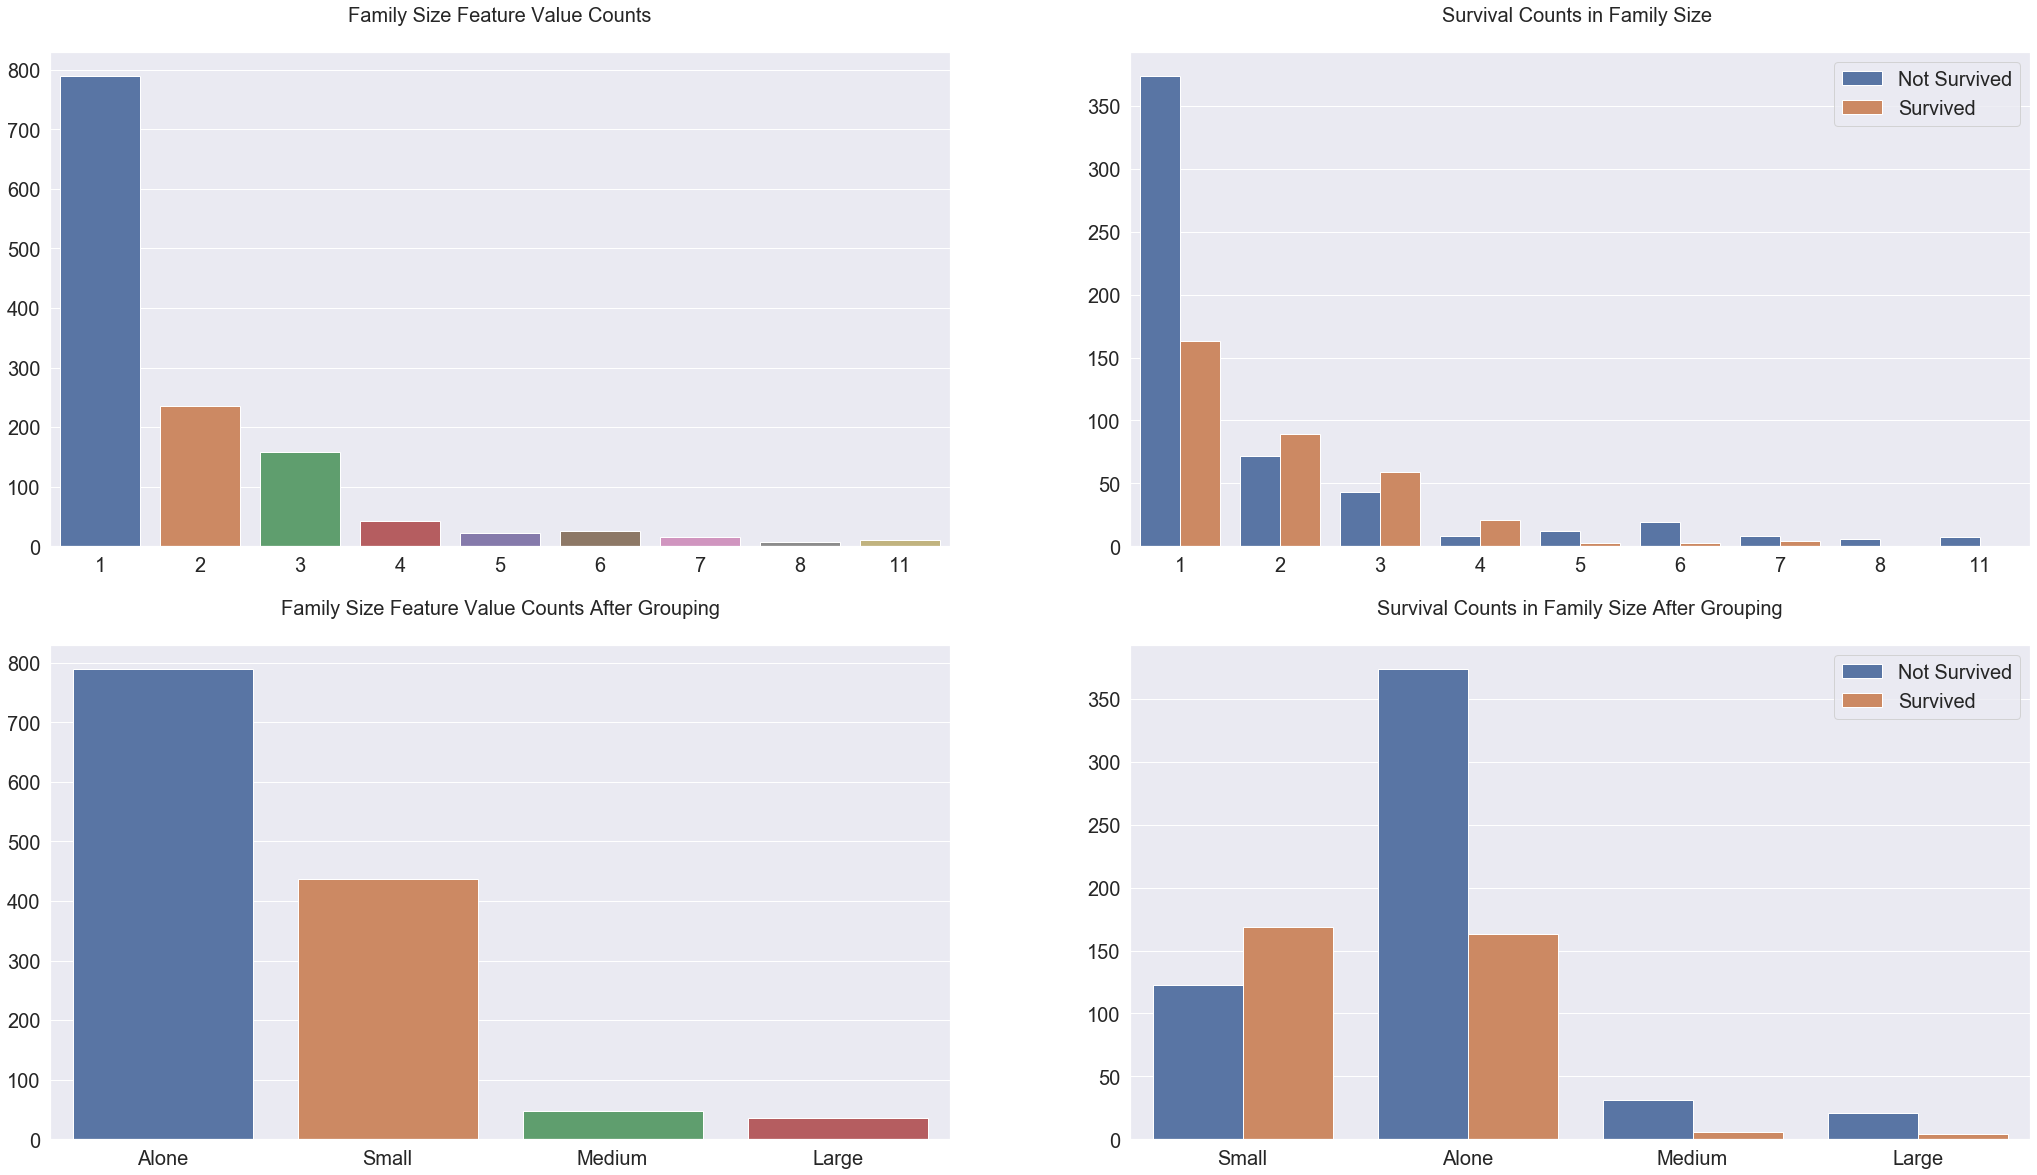

In [43]:
combined['Family_Size'] = combined['SibSp'] + combined['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=combined['Family_Size'].value_counts().index,
            y=combined['Family_Size'].value_counts().values,
            ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=combined, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {
    1: 'Alone',
    2: 'Small',
    3: 'Small',
    4: 'Small',
    5: 'Medium',
    6: 'Medium',
    7: 'Large',
    8: 'Large',
    11: 'Large'
}
combined['Family_Size_Grouped'] = combined['Family_Size'].map(family_map)

sns.barplot(x=combined['Family_Size_Grouped'].value_counts().index,
            y=combined['Family_Size_Grouped'].value_counts().values,
            ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped',
              hue='Survived',
              data=combined,
              ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping',
                    size=20,
                    y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping',
                    size=20,
                    y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'],
                     loc='upper right',
                     prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

**Feature Engineering on the Ticket Feature**

In [44]:
combined['Ticket_Frequency'] = combined.groupby('Ticket')['Ticket'].transform('count')

In [45]:
combined['Ticket_Frequency'].head()

0    1
1    2
2    1
3    2
4    1
Name: Ticket_Frequency, dtype: int64

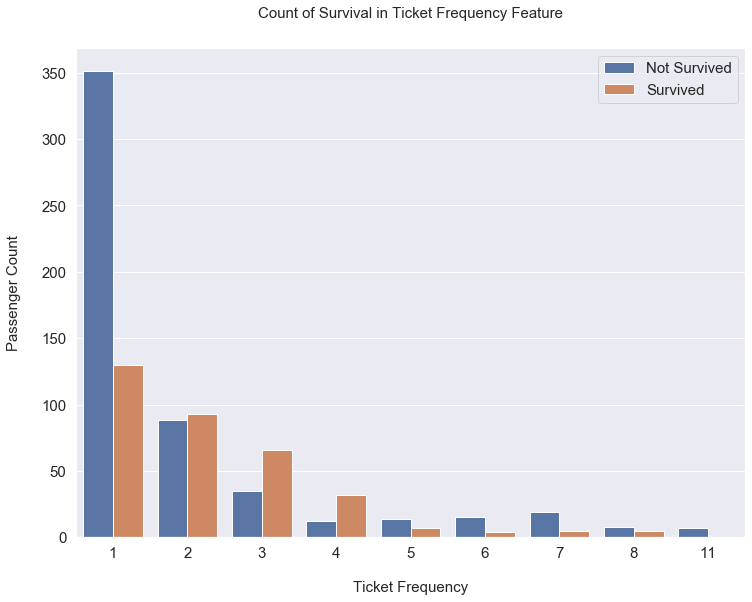

In [46]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=combined)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

**Feature Engineering the Name column**

In [47]:
combined['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [48]:
combined['Title'] = combined['Name'].str.split(
    ', ', expand=True)[1].str.split('.', expand=True)[0]
combined['Is_Married'] = 0
combined['Is_Married'].loc[combined['Title'] == 'Mrs'] = 1

In [49]:
combined[['Title', 'Is_Married', 'Name']].head()

,Title,Is_Married,Name
0,Mr,0,"Braund, Mr. Owen Harris"
1,Mrs,1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,0,"Heikkinen, Miss. Laina"
3,Mrs,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,0,"Allen, Mr. William Henry"


In [50]:
combined['Title'] = combined['Name'].str.split(
    ', ', expand=True)[1].str.split('.', expand=True)[0]
combined['Is_Married'] = 0
combined['Is_Married'].loc[combined['Title'] == 'Mrs'] = 1

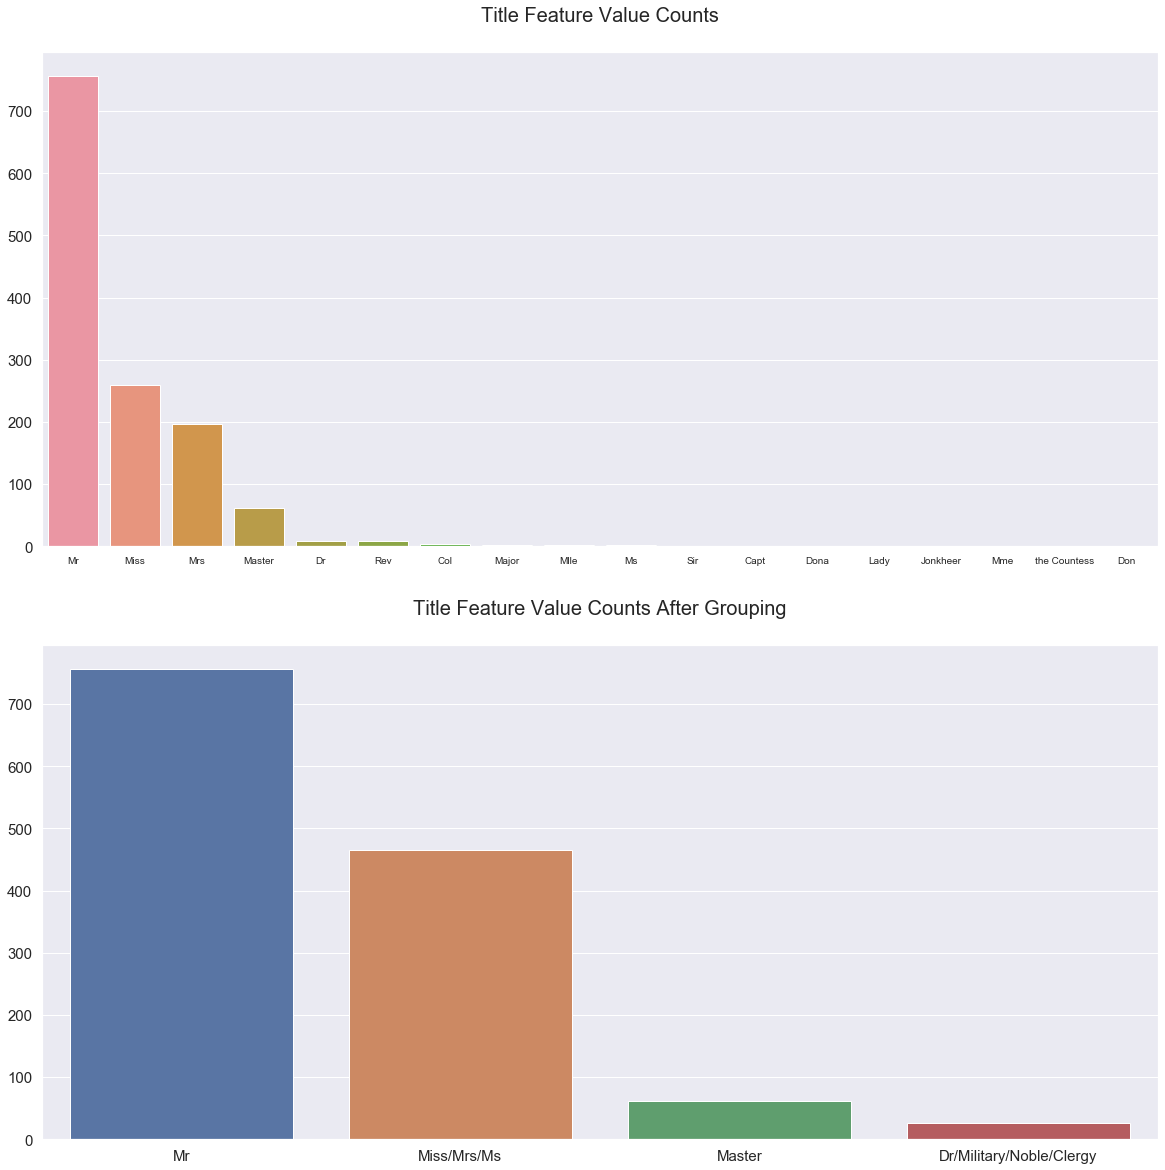

In [51]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=combined['Title'].value_counts().index,
            y=combined['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

combined['Title'] = combined['Title'].replace(
    ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
combined['Title'] = combined['Title'].replace(
    ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=combined['Title'].value_counts().index,
            y=combined['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

**Creating a Family feature using the last name from Names**

In [52]:
train.shape, test.shape 

((891, 12), (418, 11))

In [53]:
train.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'HasCabin'],
      dtype='object')

In [54]:
test.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Ticket', 'HasCabin'],
      dtype='object')

In [55]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

combined['Family'] = extract_surname(combined['Name'])
train = combined.loc[:890]
test = combined.loc[891:]
train_test = [train, test]

In [56]:
train.shape, test.shape

((891, 18), (418, 18))

In [57]:
train.columns

Index(['Age', 'Embarked', 'Fare', 'HasCabin', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size',
       'Family_Size_Grouped', 'Ticket_Frequency', 'Title', 'Is_Married',
       'Family'],
      dtype='object')

In [58]:
test.columns

Index(['Age', 'Embarked', 'Fare', 'HasCabin', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size',
       'Family_Size_Grouped', 'Ticket_Frequency', 'Title', 'Is_Married',
       'Family'],
      dtype='object')

In [59]:
combined['Family'].head()

0       Braund
1      Cumings
2    Heikkinen
3     Futrelle
4        Allen
Name: Family, dtype: object

In [60]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [
    x for x in train['Family'].unique() if x in test['Family'].unique()
]
non_unique_tickets = [
    x for x in train['Ticket'].unique() if x in test['Ticket'].unique()
]

df_family_survival_rate = train.groupby('Family')['Survived', 'Family',
                                                     'Family_Size'].median()
df_ticket_survival_rate = train.groupby('Ticket')[
    'Survived', 'Ticket', 'Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[
            i] in non_unique_families and df_family_survival_rate.iloc[i,
                                                                       1] > 1:
        family_rates[
            df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i,
                                                                             0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[
            i] in non_unique_tickets and df_ticket_survival_rate.iloc[i,
                                                                      1] > 1:
        ticket_rates[
            df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i,
                                                                             0]

In [61]:
train.shape, test.shape

((891, 18), (418, 18))

In [62]:
mean_survival_rate = np.mean(train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(train)):
    if train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(test)):
    if test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
train['Family_Survival_Rate'] = train_family_survival_rate
train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
test['Family_Survival_Rate'] = test_family_survival_rate
test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(train)):
    if train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(test)):
    if test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
train['Ticket_Survival_Rate'] = train_ticket_survival_rate
train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
test['Ticket_Survival_Rate'] = test_ticket_survival_rate
test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [63]:
train.shape, test.shape

((891, 22), (418, 22))

In [64]:
for df in [train, test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] +
                           df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] +
                              df['Family_Survival_Rate_NA']) / 2

In [65]:
train.shape, test.shape

((891, 24), (418, 24))

In [66]:
train[[
    'Family_Survival_Rate', 'Family_Survival_Rate_NA', 'Ticket_Survival_Rate',
    'Ticket_Survival_Rate_NA', 'Survival_Rate', 'Survival_Rate_NA'
]].head()

,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA,Survival_Rate,Survival_Rate_NA
0,0.383838,0,0.383838,0,0.383838,0.0
1,1.000000,1,1.000000,1,1.000000,1.0
2,0.383838,0,0.383838,0,0.383838,0.0
3,0.383838,0,0.383838,0,0.383838,0.0
4,0.383838,0,0.383838,0,0.383838,0.0


**Feature Transformation**

*Label Encoding Non-Numerical Features*

*`LabelEncoder` basically labels the classes from **0** to **n**. This process is necessary for models to learn from those features*

*Medium Article on Label Encoding: https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621*

In [67]:
train.dtypes

Age                        category
Embarked                     object
Fare                       category
HasCabin                       bool
Name                         object
Parch                         int64
PassengerId                   int64
Pclass                        int64
Sex                          object
SibSp                         int64
Survived                    float64
Ticket                       object
Family_Size                   int64
Family_Size_Grouped          object
Ticket_Frequency              int64
Title                        object
Is_Married                    int64
Family                       object
Family_Survival_Rate        float64
Family_Survival_Rate_NA       int64
Ticket_Survival_Rate        float64
Ticket_Survival_Rate_NA       int64
Survival_Rate               float64
Survival_Rate_NA            float64
dtype: object

In [68]:
non_numeric_features = ['Embarked', 'HasCabin', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in train_test:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [69]:
train.shape, test.shape

((891, 24), (418, 24))

**One-Hot Encoding the Categorical Features**

In [70]:
cat_features = ['Pclass', 'Sex', 'HasCabin','Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in train_test:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(
            df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

train = pd.concat([train, *encoded_features[:6]], axis=1)
test = pd.concat([test, *encoded_features[6:]], axis=1)

**Concluding Feature Engineering**

*Finally, the non-numeric type features are label encoded, categorical features are one-hot encoded.*

*Added 5 new features (Family_Size, Title, Is_Married, Survival_Rate and Survival_Rate_NA)*

*Dropped the needless features after encoding.*

In [71]:
combined = concat_df(train, test)
drop_cols = ['Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

combined.drop(columns=drop_cols, inplace=True)

combined.head()

,Age,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Fare,HasCabin,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11,1,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,1,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


**Model Training**

In [72]:
X_train = StandardScaler().fit_transform(train.drop(columns=drop_cols))
y_train = train['Survived'].values
X_test = StandardScaler().fit_transform(test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 25)
y_train shape: (891,)
X_test shape: (418, 25)


**Two RandomForestClassifier's. One of them is a single model and the other is for k-fold cross validation**

*Medium Article: https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f*

*https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833*

In [73]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

**StratifiedKFold is used for stratifying the target variable. The folds are made by preserving the percentage of samples for each class in target variable (Survived).**

In [74]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)),
                     columns=[
                         'Fold_{}_Prob_{}'.format(i, j)
                         for i in range(1, N + 1) for j in range(2)
                     ])
importances = pd.DataFrame(
    np.zeros((X_train.shape[1], N)),
    columns=['Fold_{}'.format(i) for i in range(1, N + 1)],
    index=combined.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))

    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])

    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(
        y_train[trn_idx],
        leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(
        y_train[val_idx],
        leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)

    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

    # X_test probabilities
    probs.loc[:,
              'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(
                  X_test)[:, 0]
    probs.loc[:,
              'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(
                  X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_

    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))

print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 1 OOB Score: 0.8525280898876404

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 3 OOB Score: 0.8513323983169705

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 4 OOB Score: 0.8302945301542777

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 5 OOB Score: 0.8288920056100981

Average OOB Score: 0.8414733599130118


**Feature importance**

*Medium Article on Feature Importance: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e*

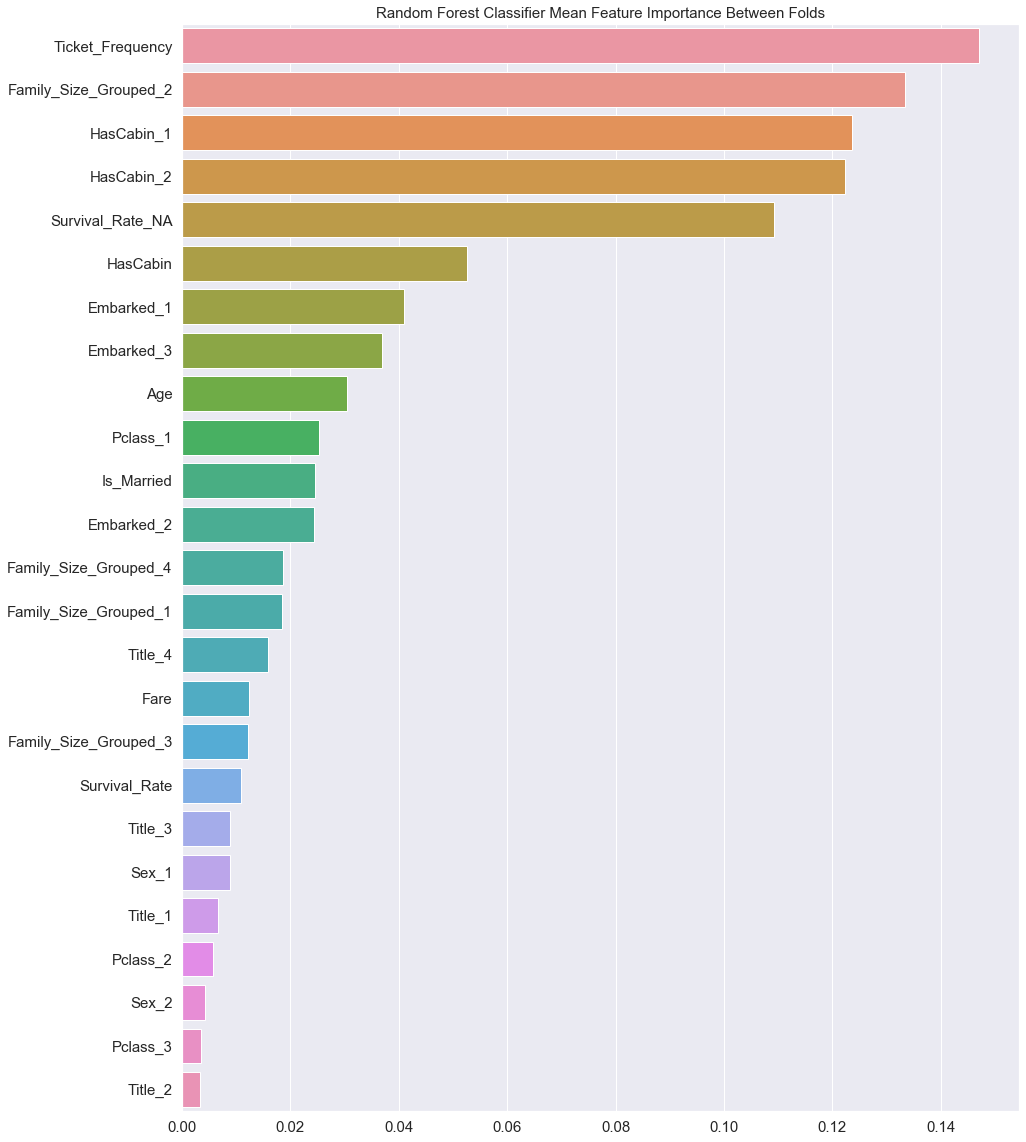

In [75]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

**ROC Curve**

*A medium Article on AUC & ROC Curve: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5*

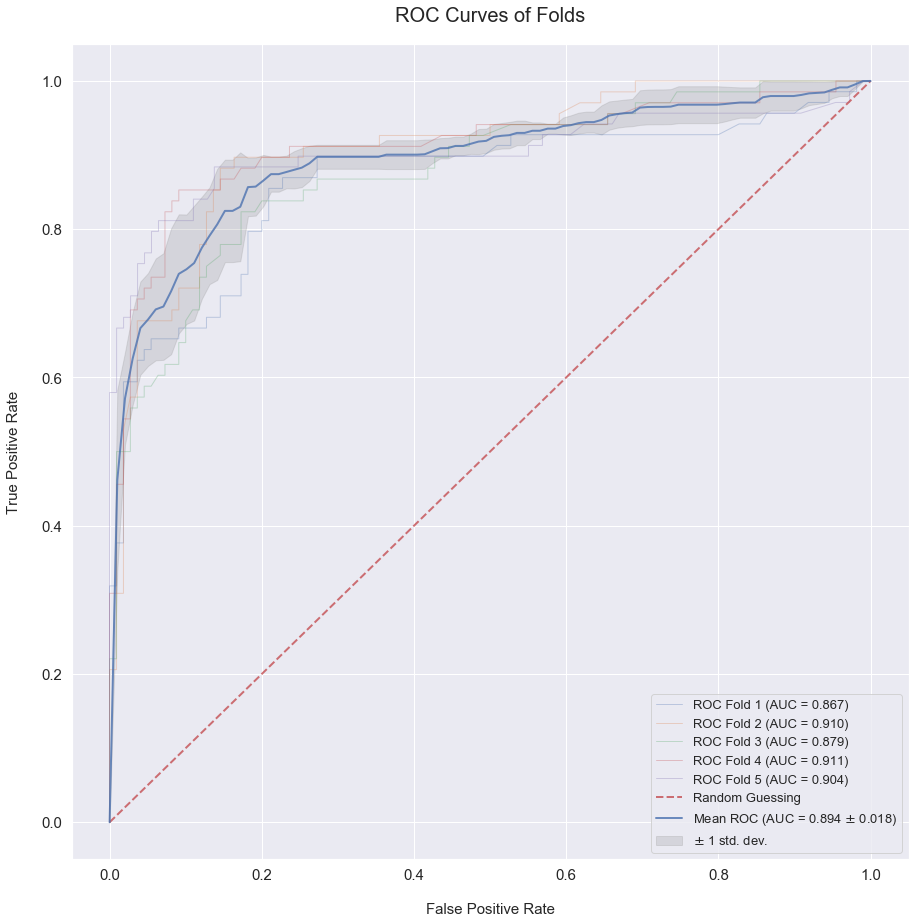

In [76]:
def plot_roc_curve(fprs, tprs):

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))

    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))

    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
             color='r', alpha=0.8, label='Random Guessing')

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(
        mean_auc, std_auc), lw=2, alpha=0.8)

    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                    color='grey', alpha=.2, label='$\pm$ 1 std. dev.')

    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})

    plt.show()


plot_roc_curve(fprs, tprs)

**Submission**

In [77]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
